In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import norm
import random as rand
import warnings

# environment settings
data_path = 'Data/'
warnings.filterwarnings('ignore')

# Deserialize previously saved data from "preprocessing"
filehandler = open(data_path+'train_pp.obj', 'rb')
df = pickle.load(filehandler)
filehandler.close()

#open test set
test_path = data_path+"test.csv"
test_df = pd.read_csv(test_path, dtype={
    'PassengerId': str,
    'Pclass': 'category', # Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
    'Name': str,
    'Sex': 'category',
    'Age': float,
    'SibSp': 'uint8', # number of siblings/spouses aboard
    'Parch': 'uint8', # number of parents/children aboard
    'Ticket': str, # Ticket number
    'Fare': float, # Passenger fare
    'Cabin': str, # Cabin number
    'Embarked': 'category'}) # Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
def plot_cv_accuracy(classifier):
    train_sizes,train_scores,test_scores =\
                        learning_curve(estimator=classifier,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)
    
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(train_sizes,train_mean,color='blue',marker='o' ,markersize=5,label='training accuracy')
    plt.fill_between(train_sizes,train_mean+train_std, train_mean-train_std, alpha=0.15,color='blue')
    plt.plot(train_sizes,test_mean,color='green',linestyle="--",marker='s',markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6 ,1.1])
    plt.show()

In [3]:
def plot_cv_overfitting(classifier,param, param_range):
    train_scores,test_scores= validation_curve(estimator=classifier,
                                              X=X_train,
                                              y=y_train,
                                              param_name=param,
                                              param_range=param_range,
                                              cv=10)
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    test_std = np.std(test_scores,axis=1)
    
    fig = plt.figure(figsize=(10,5))
    
    plt.plot(param_range,train_mean,color='blue',marker='o' ,markersize=5,label='training accuracy')
    plt.fill_between(param_range,train_mean+train_std, train_mean-train_std, alpha=0.15,color='blue')
    plt.plot(param_range,test_mean,color='green',linestyle="--",marker='s',markersize=5,label='validation accuracy')
    plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
    plt.grid()
    plt.xscale('log')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6 ,1.1])
    plt.show()

In [4]:
#Separate training set from target variables
y = np.asarray(df['Survived'])
X = df
X = X.drop(['Survived','Embarked','Name'], axis=1)
X = np.asarray(X)
X_train , X_test ,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)

test_df = test_df.drop(['Ticket','Cabin'], axis=1)
test_df['Sex'] = [0 if x == 'male' else 1 for x in test_df['Sex'] ]
# Replace Age missing values with data generated from gaussian
nan_filter = test_df['Age'].isnull()
np.random.seed(666)
mu, sigma = norm.fit(test_df[-nan_filter]['Age'])
norm_dist = np.random.normal(mu, sigma, nan_filter.sum())
test_df.loc[nan_filter,'Age'] = norm_dist
# Replace Fare missing values with data generated from gaussian
nan_filter = test_df['Fare'].isnull()
np.random.seed(666)
mu, sigma = norm.fit(test_df[-nan_filter]['Fare'])
norm_dist = np.random.normal(mu, sigma, nan_filter.sum())
test_df.loc[nan_filter,'Fare'] = norm_dist
# set to zero all ages below zero
test_df.loc[df.Age<0 , 'Age'] = 0
test_set = test_df
test_set=test_set.drop(['Embarked','Name'], axis=1)



CV accuracy : 0.8061144645651688 +/- 0.030164809079871503
Test Accuracy :0.8324022346368715


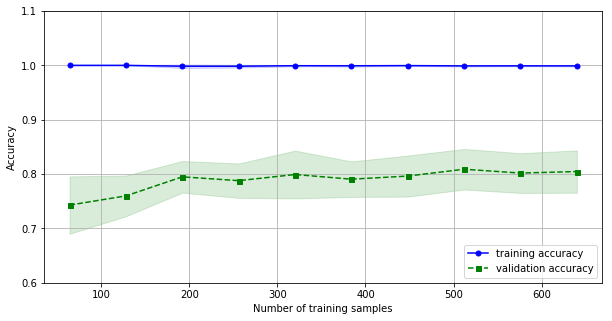

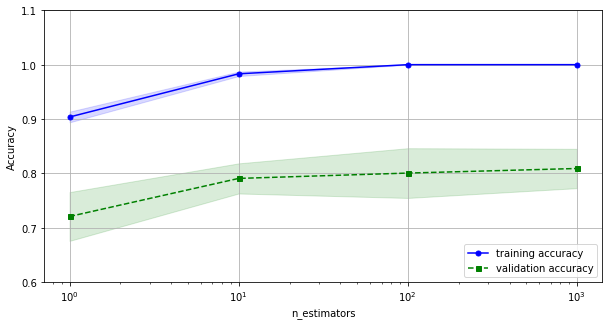

AdaBoost train/test accuracies 1.0/0.8435754189944135


In [13]:
import sklearn.ensemble as ske
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
rf = ske.RandomForestClassifier(n_estimators=50,max_features=3).fit(X_train, y_train)
ada = AdaBoostClassifier(base_estimator=rf, n_estimators=10,learning_rate=0.1,random_state=1)
scores= []
for k,(train,test) in enumerate(kfold):
    rf.fit(X_train[train], y_train[train])
    score_train_rf = rf.score(X_train[test],y_train[test])
    scores.append(score_train_rf)
print("\nCV accuracy : {} +/- {}".format(np.mean(scores),np.std(scores)))
score_test_rf=rf.score(X_test,y_test)
print("Test Accuracy :{}".format(score_test_rf))
plot_cv_accuracy(rf)
plot_cv_overfitting(rf,'n_estimators',[1,10,100,1000])
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print("AdaBoost train/test accuracies {}/{}".format(ada_train,ada_test))


In [12]:
survival_results =ada.predict(test_set)
passengerId= test_df['PassengerId'].values
result = {'PassengerId':passengerId , 'Survived':survival_results}
result_df = pd.DataFrame(data=result)
result_df['Survived'] = [0 if x == False else 1 for x in result_df['Survived'] ]
result_df.to_csv(data_path+"outputs/randomforest_ne_50_with_ada_ne_10.csv",index=False)